<a href="https://colab.research.google.com/github/iMan0405/Portfolio_DT_vs_AI/blob/main/Yolo_Car_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kutubxonalarni yuklash

In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time


!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16094, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 16094 (delta 0), reused 4 (delta 0), pack-reused 16089
Receiving objects: 100% (16094/16094), 14.82 MiB | 14.30 MiB/s, done.
Resolving deltas: 100% (11023/11023), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.
cp: missing destination file operand after 'yolov5/requirements

### Ma'lumotlarni yuklash

In [3]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/drive/MyDrive/Yolo/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [4]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f"/content/drive/MyDrive/Yolo/data/training_images/{image}.jpg")
img.shape

Image ID: vid_4_26340


(380, 676, 3)

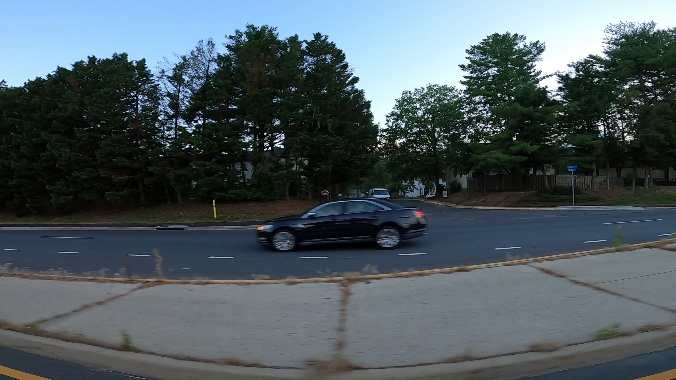

In [5]:
image = random.choice(index)
Image(filename=f'/content/drive/MyDrive/Yolo/data/training_images/{image}.jpg', width=600)

# Modelni o'qitish

In [ ]:
source = 'training_images'
if True:
  for fold in [0]:
    val_index = index[len(index) * fold // 5:len(index) * (fold+1) // 5]
    for name, mini in tqdm(df.groupby('image_id')):
      if name in val_index:
        path2save = 'val2017/'
      else:
        path2save = 'train2017/'
      if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold) + path2save):
        os.makedirs('tmp/convertor/fold{}/labels/'.format(fold) + path2save)

      source_folder = "/content/drive/MyDrive/Yolo/data/{}/".format(source)
      destination_folder = "/tmp/convertor/fold{}/labels/{}".format(fold, path2save)

      source_files = os.listdir(source_folder)
      destination_files = [os.path.join(destination_folder, file) for file in source_files]

      for source, destination in zip(source_files, destination_files):
        try:
          sh.copy(os.path.join(source_folder, source), destination)
        except FileNotFoundError as e:
          print(f"Faylni ko'chirib bo'lmadi: {source}. Xatolik: {e}")

      with open('/tmp/convertor/fold{}/labels/'.format(fold) + path2save + name + '.jpg', 'w+') as f:
        row = mini[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
          text = ' '.join(row[j])
          f.write(text)
          f.write("\n")
        if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold, path2save)):
          os.makedirs('tmp/convertor/fold{}/images/{}'.format(fold, path2save))

        source_folder = "/content/drive/MyDrive/Yolo/data/{}/{}.jpg".format(source, name)
        destination_folder = "/tmp/convertor/fold{}/images/{}/{}.jpg".format(fold, path2save, name)

        source_files = os.listdir(source_folder)
        destination_files = [os.path.join(destination_folder, file) for file in source_files]

        for source, destination in zip(source_files, destination_files):
          try:
            sh.copy(os.path.join(source_folder, source), destination)
          except FileNotFoundError as e:
           print(f"Faylni ko'chirib bo'lmadi: {source}. Xatolik: {e}")

In [8]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/drive/MyDrive/Yolo/data/training_images

detect: weights=['yolov5/yolov5s.pt'], source=/content/drive/MyDrive/Yolo/data/training_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-249-gf400bba Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/1001 /content/drive/MyDrive/Yolo/data/training_images/vid_4_1000.jpg: 416x704 1 car, 44.6ms
image 2/1001 /content/drive/MyDrive/Yolo/data/training_images/vid_4_10000.jpg: 416x704 1 car, 9.5ms
image 3/

In [13]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("/content/yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)

In [14]:
Image(filename=f'/content/yolov5/runs/detect/exp/{random.choice(predicted_files)}')

IndexError: ignored